In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.integrate import simps
import os
import pymaster as nmt
import sacc
from astropy.table import Table
from scipy.interpolate import interp1d

This notebook shows how to obtain the power spectra and covariance matrices used in the analysis from the Quaia catalog and selection functions. Some details of the analysis are not reflected below, though:
- Systematics deprojection.
- DIR estimation of the $p(z)$.
- Marginalisation over $p(z)$ uncertainties or shot noise amplitude in the covariance.

We hope to include the code used for these steps in the future.

## 1 Read and cut catalog

In [2]:
nside = 512
npix = hp.nside2npix(nside)
num_z_bins = 500
zname = 'redshift_quaia'

cat = Table.read('../fits/Gaia_QSOs/quaia_G20.5.fits')
zs = sorted(cat[zname])
z_edges = np.array([0, zs[int(len(cat)/3)], 2* zs[int(len(cat)/3)],  5])
# Low redshift bin
cat1 = cat[(cat[zname] < z_edges[1]) &
           (cat[zname] >= z_edges[0])]

#Middle redshift bin
cat2 = cat[(cat[zname] < z_edges[2]) &
           (cat[zname] >= z_edges[1])]

# High redshift bin
cat3 = cat[(cat[zname] < z_edges[3]) &
           (cat[zname] >= z_edges[2])]
print("Redshift edges: ", z_edges)
cats = [cat1, cat2, cat3]

Redshift edges:  [0.         1.16403449 2.32806897 5.        ]


## 2 Read selection functions

In [3]:
sels = [hp.ud_grade(hp.read_map(f"../fits/Gaia_QSOs/selection_function_NSIDE64_G20.5_zsplit2bin0.fits"),
                    nside_out=nside)
        for i in range(3)]

## 3 Process galaxy maps
- Get thresholded window function.
- Compute overdensity map.
- Compute redshift distribution via PDF stacking.
- Compute coupled noise power spectrum.
- Generate NaMaster field.

In [4]:
def process_catalog(cat, sel, sel_threshold=0.5):
    # Threshold selection function
    mask_b = sel > sel_threshold
    mask = sel.copy()
    mask[~mask_b] = 0.0

    # Get angular mask and cut catalog
    ipix = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
    maskflag = mask_b[ipix]
    c = cat[maskflag]
    ipix = ipix[maskflag]

    # Get redshift distribution via PDF stacking
    zs = np.linspace(0., 4.5, num_z_bins)
    sz = c[zname+'_err']
    zm = c[zname]
    nz = np.array([np.sum(np.exp(-0.5*((z-zm)/sz)**2)/sz)
                   for z in zs])

    # Calculate overdensity field
    nmap = np.bincount(ipix, minlength=npix)
    nmean = np.sum(nmap*mask_b)/np.sum(mask*mask_b)
    delta = np.zeros(npix)
    delta[mask_b] = nmap[mask_b]/(nmean*mask[mask_b])-1

    # Calculate coupled noise power spectrum
    nmean_srad = nmean * npix / (4*np.pi)
    nl_coupled = np.mean(mask) / nmean_srad * np.ones((1, 3*nside))

    # Compute NaMaster field
    f = nmt.NmtField(mask, [delta], n_iter=0)

    # Return everything in a dictionary
    return {'map': delta, 'mask': mask, 'field': f, 'cat': c, 'nl_coupled': nl_coupled, 'dndz': (zs, nz)}

maps = {}
for i in range(3):
    maps[f'qso{i}'] = process_catalog(cats[i], sels[i])

Make a few plots

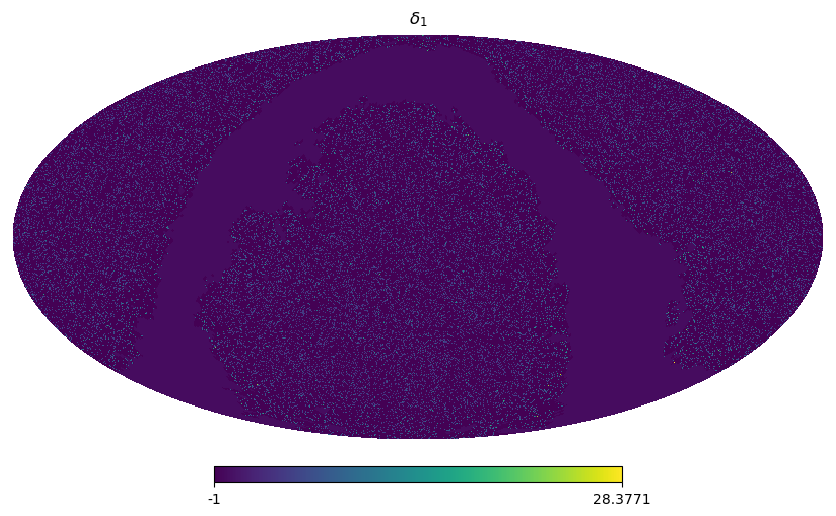

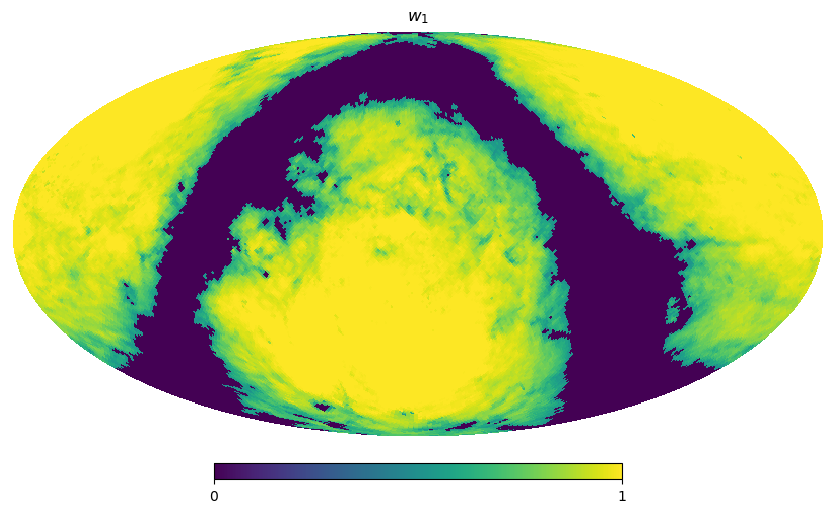

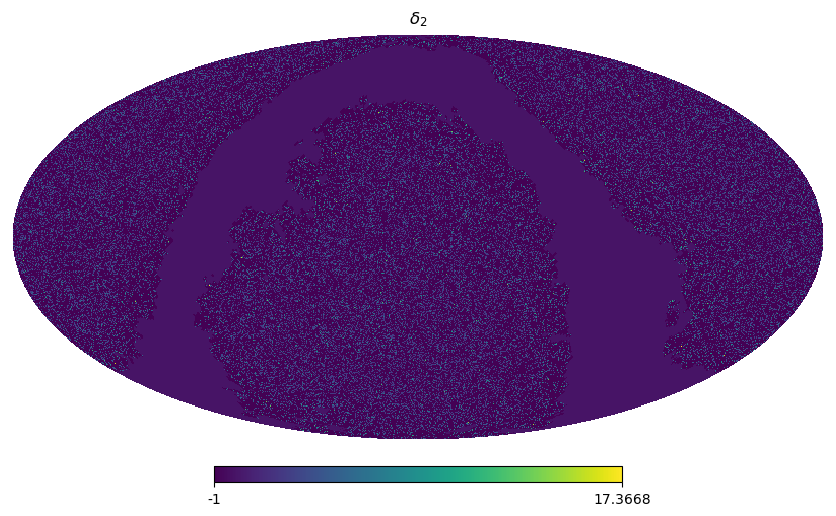

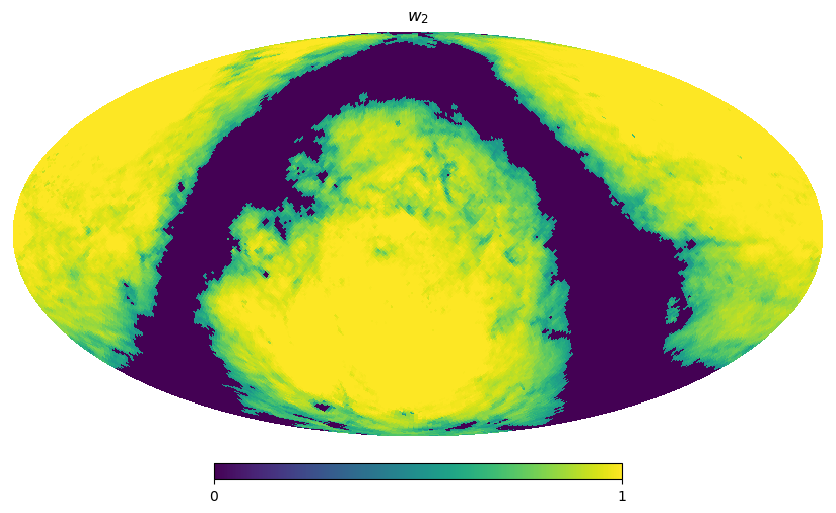

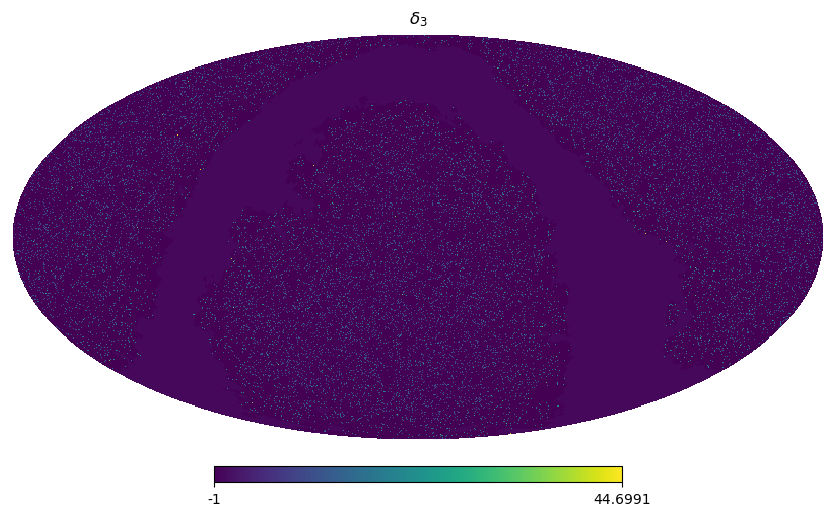

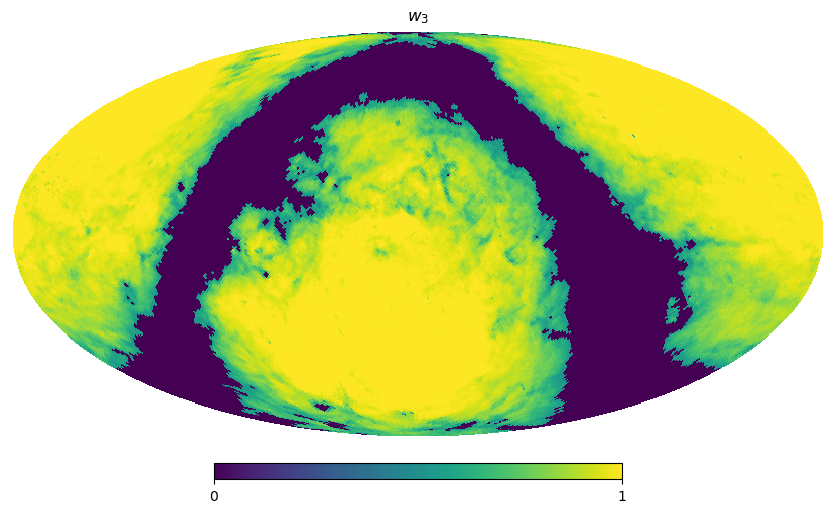

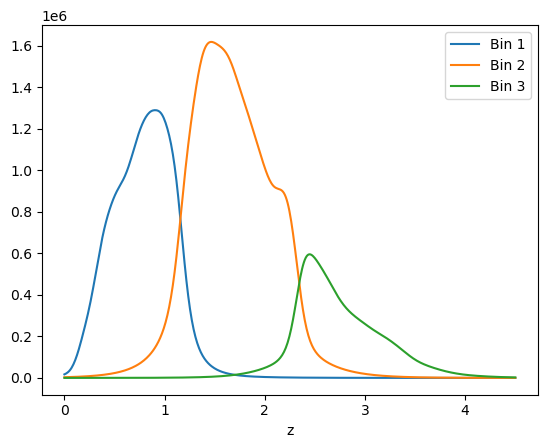

In [5]:
# Plot maps and selection function
for i in range(3):
    hp.mollview(maps[f'qso{i}']['map'], title=f'$\\delta_{i+1}$')
    hp.mollview(maps[f'qso{i}']['mask'], title=f'$w_{i+1}$')

# Plot redshift distribution
plt.figure()
for i in range(3):
    z, nz = maps[f'qso{i}']['dndz']
    plt.plot(z, nz, label=f'Bin {i+1}')
plt.legend()
plt.xlabel('z');

## 4 Prepare tSZ map
- Read alms and rotate to Equatorial coordinates.
- Truncate to target resolution.
- Transform to map.
- Read mask and rotate to Equatorial coordinates.
- Apodize (0.2 degrees, C1).
- Binarize and downgrade to target resolution.
- Save all to file to avoid recomputing (since these operations are always the same).
- Read and interpolate Planck transfer function

In [6]:
# coordinate rotator
def change_coord(m, coord):

    # Basic HEALPix parameters                                                                 
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation                                                     
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates                                                                  
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]
#map = change_coord(map,['C','G'])

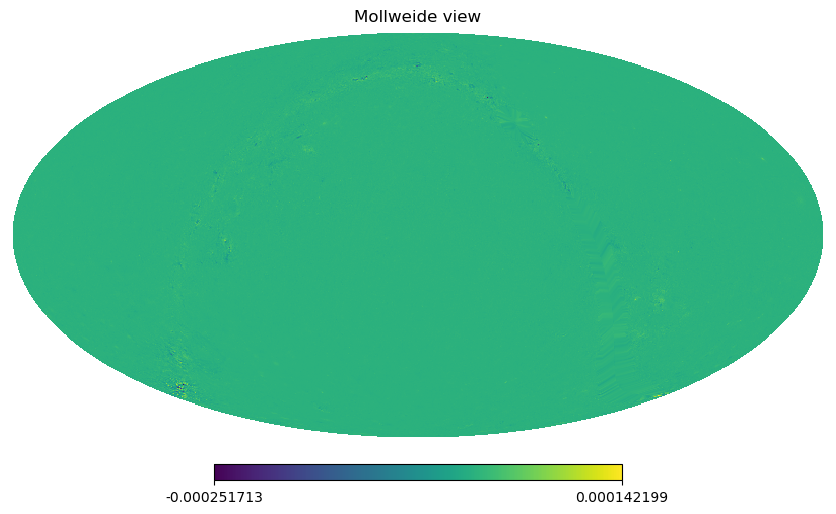

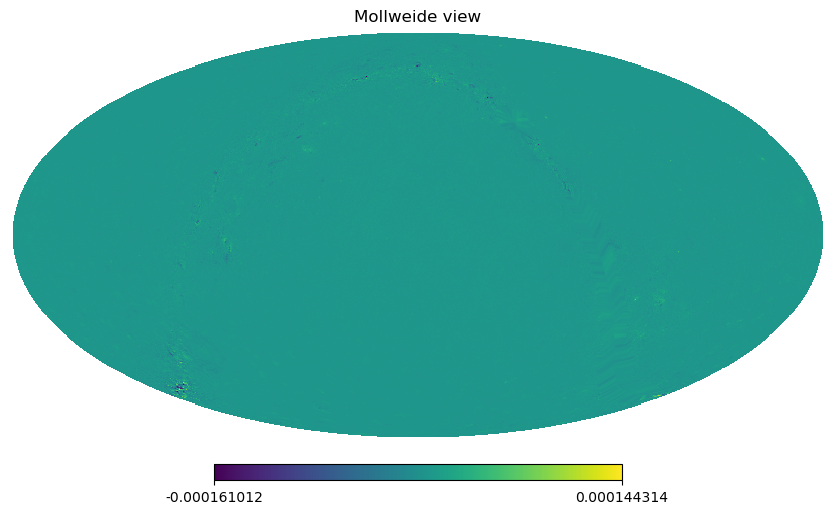

3145728


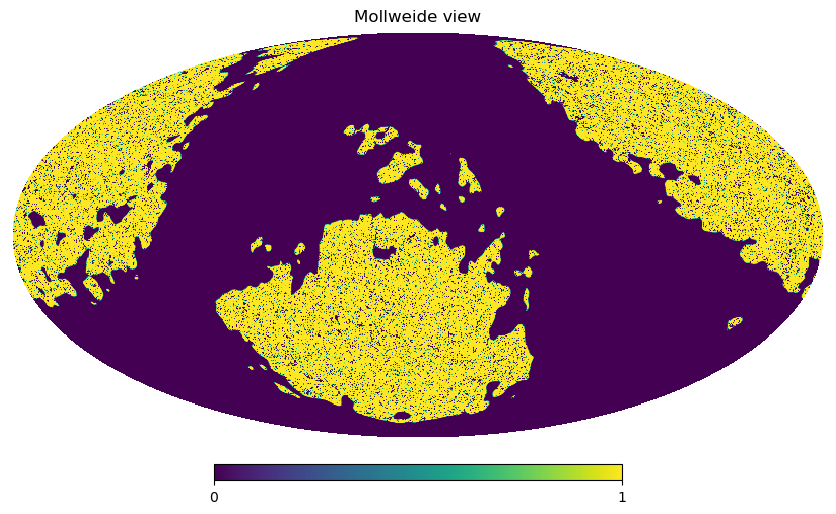

In [7]:
# tSZ map
ymaps_G = [hp.ud_grade(hp.read_map("../fits/tSZ/FMcC_JCH_2023/deproject_CIB_default_standard_full.fits"), nside_out=nside), hp.ud_grade(hp.read_map("../fits/tSZ/FMcC_JCH_2023/no_deprojection_standard_full.fits"),
nside_out=nside)]

ymaps = [change_coord(ymaps_G[0],['G','C']), change_coord(ymaps_G[1],['G','C'])]

hp.mollview(ymaps[0])
hp.mollview(ymaps[1])
plt.show()

# Mask
## already celestrial coord
ymask = hp.ud_grade(hp.read_map("../fits/tSZ/mask_mask_P15tSZ_coordC_ns1024.fits"), nside_out=nside)
print(ymask.size)
hp.mollview(ymask)
plt.show()

# Field
fy = [nmt.NmtField(ymask, [ymaps[i]], n_iter=0) for i in range(2)]

#ymap0: CIB deproj., ymap1: no deproj.
for i in range(2):
    maps[f'ymap{i}'] = {'map': ymaps[i], 'mask': ymask, 'field': fy[i]}

# Transfer function
#d = np.loadtxt("data/mc_correction_selfunc_masks.dat", unpack=True)
#gk_transfer = interp1d(d[0], d[1], bounds_error=False, fill_value=(d[1][0], d[1][-1]))

## 5 Compute power spectra
Write generic calculator computing power spectrum, mode-coupling matrix, noise bias, and bandpower window functions

In [8]:
# Bins
b = nmt.NmtBin(nside, nlb=30)
leff = b.get_effective_ells()
#t_gk = gk_transfer(leff)

# Calculator
def get_cl(f1, f2, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

$C_\ell$ iterator. This is the order in which power spectra will be calculated and stored.

In [9]:
map_names = list(maps.keys())
print(map_names)
print(maps['qso0'].keys())

def cl_iter():
    icl = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated
            if i2 < i1:
                continue
            cl_name = f'{nm1}_{nm2}'
            yield icl, i1, i2, nm1, nm2, cl_name
            icl += 1

['qso0', 'qso1', 'qso2', 'ymap0', 'ymap1']
dict_keys(['map', 'mask', 'field', 'cat', 'nl_coupled', 'dndz'])


Calculate all relevant $C_\ell$s.

In [10]:
cls = {}
for icl, _, _, nm1, nm2, cl_name in cl_iter():
    print(cl_name)
    fg1 = maps[nm1]['field']
    fg2 = maps[nm2]['field']
    if (nm1 == 'qso0' or nm1 == 'qso1' or nm1 == 'qso2' ):
        pnl = maps[nm1]['nl_coupled'] if nm1 == nm2 else None
    else:
        pnl = None
    cl, nl, w, Bbl = get_cl(fg1, fg2, pnl=pnl)
    cls[cl_name] = {'cl': cl, 'nl': nl, 'Bbl': Bbl, 'w': w}

qso0_qso0
qso0_qso1
qso0_qso2
qso0_ymap0
qso0_ymap1
qso1_qso1
qso1_qso2
qso1_ymap0
qso1_ymap1
qso2_qso2
qso2_ymap0
qso2_ymap1
ymap0_ymap0
ymap0_ymap1
ymap1_ymap1


## 6 Calculate covariances
First write generic covariance calculator which stores precomputed covariance workspaces.

In [11]:
cws = {}

def get_cov(f1, f2, f3, f4, w12, w34):
    fs = [f1, f2, f3, f4]
    #ms = [f.get_mask() for f in fs]
    # Compute all pseudo-Cls
    #cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j]) for i in range(4)] for j in range(4)])
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j]) for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [12]:
n_cls = len(cls.keys())
n_ell = len(cls['qso0_qso0']['cl'][0])

Covariance without deprojection 

In [13]:
cov = []
for i1, _, _, _, _, _ in cl_iter():
    cov.append([])
    for i2, _, _, _, _, _ in cl_iter():
        cov[i1].append(np.zeros([n_ell, n_ell]))

for icl1, _, _, nm1, nm2, cl_name12 in cl_iter():
    f1 = maps[nm1]['field']
    f2 = maps[nm2]['field']
    w12 = cls[cl_name12]['w']
    for icl2, _, _, nm3, nm4, cl_name34 in cl_iter():
        print(nm1, nm2, nm3, nm4)
        f3 = maps[nm3]['field']
        f4 = maps[nm4]['field']
        w34 = cls[cl_name34]['w']
        if icl2 < icl1:
            cv = cov[icl2][icl1].T
        else:
            cv = get_cov(f1, f2, f3, f4, w12, w34)
        if icl1 == icl2:
            cls[cl_name12]['cov'] = cv
        cov[icl1][icl2] = cv
cov_blocks = np.array(cov)
cov_all = np.transpose(cov_blocks, axes=[0, 2, 1, 3]).reshape([n_cls*n_ell, n_cls*n_ell])

qso0 qso0 qso0 qso0
qso0 qso0 qso0 qso1
qso0 qso0 qso0 qso2
qso0 qso0 qso0 ymap0
qso0 qso0 qso0 ymap1
qso0 qso0 qso1 qso1
qso0 qso0 qso1 qso2
qso0 qso0 qso1 ymap0
qso0 qso0 qso1 ymap1
qso0 qso0 qso2 qso2
qso0 qso0 qso2 ymap0
qso0 qso0 qso2 ymap1
qso0 qso0 ymap0 ymap0
qso0 qso0 ymap0 ymap1
qso0 qso0 ymap1 ymap1
qso0 qso1 qso0 qso0
qso0 qso1 qso0 qso1
qso0 qso1 qso0 qso2
qso0 qso1 qso0 ymap0
qso0 qso1 qso0 ymap1
qso0 qso1 qso1 qso1
qso0 qso1 qso1 qso2
qso0 qso1 qso1 ymap0
qso0 qso1 qso1 ymap1
qso0 qso1 qso2 qso2
qso0 qso1 qso2 ymap0
qso0 qso1 qso2 ymap1
qso0 qso1 ymap0 ymap0
qso0 qso1 ymap0 ymap1
qso0 qso1 ymap1 ymap1
qso0 qso2 qso0 qso0
qso0 qso2 qso0 qso1
qso0 qso2 qso0 qso2
qso0 qso2 qso0 ymap0
qso0 qso2 qso0 ymap1
qso0 qso2 qso1 qso1
qso0 qso2 qso1 qso2
qso0 qso2 qso1 ymap0
qso0 qso2 qso1 ymap1
qso0 qso2 qso2 qso2
qso0 qso2 qso2 ymap0
qso0 qso2 qso2 ymap1
qso0 qso2 ymap0 ymap0
qso0 qso2 ymap0 ymap1
qso0 qso2 ymap1 ymap1
qso0 ymap0 qso0 qso0
qso0 ymap0 qso0 qso1
qso0 ymap0 qso0 qso2
q

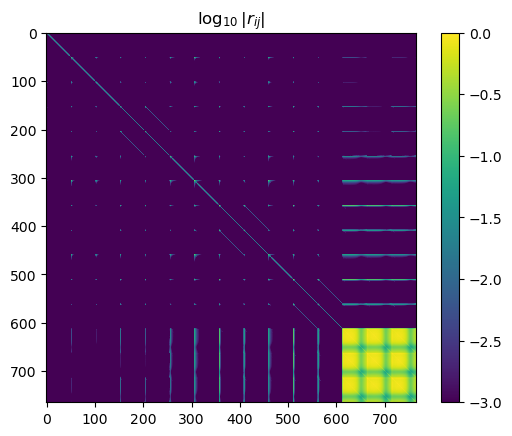

In [14]:
plt.figure()
plt.imshow(np.log10(np.fabs(cov_all/np.sqrt(np.outer(np.diag(cov_all), np.diag(cov_all))))), vmin=-3)
plt.title(r'$\log_{10}|r_{ij}|$')
plt.colorbar()

Plot stuff

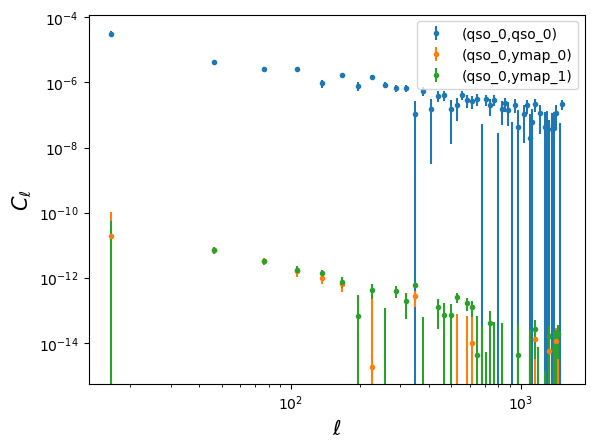

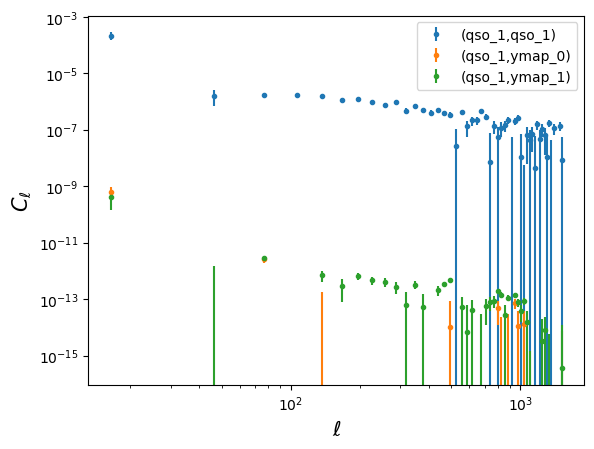

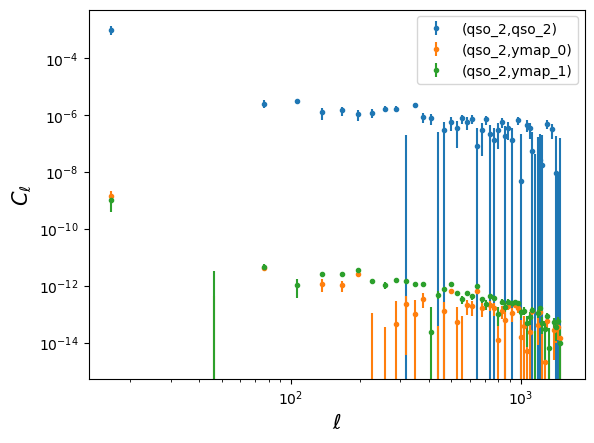

In [15]:
for i in range(3):
    plt.figure()
    d = cls[f'qso{i}_qso{i}']
    plt.errorbar(leff, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='.', label=f'(qso_{i},qso_{i})')
    
    for j in range(2):
        d = cls[f'qso{i}_ymap{j}']
        plt.errorbar(leff, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='.', label=f'(qso_{i},ymap_{j})')
        #plt.errorbar(leff, -d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='x', label=f'(qso_{i},ymap_{j})')
    plt.loglog()
    plt.xlabel(r'$\ell$', fontsize=15)
    plt.ylabel(r'$C_\ell$', fontsize=15)
    plt.legend()

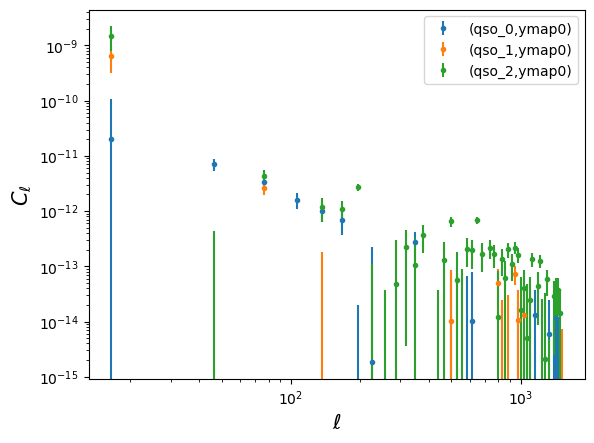

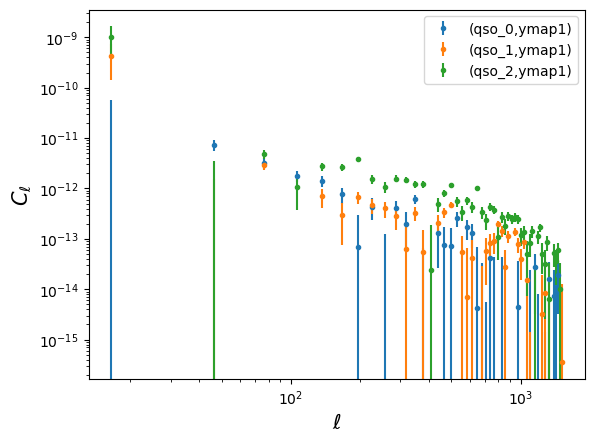

In [25]:
for j in range(2):
    plt.figure()
    for i in range(3):
        d = cls[f'qso{i}_ymap{j}']
        plt.errorbar(leff, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='.', label=f'(qso_{i},ymap{j})')
    plt.loglog()
    plt.xlabel(r'$\ell$', fontsize=15)
    plt.ylabel(r'$C_\ell$', fontsize=15)
    plt.legend()

## 7 Save $C_\ell$s to file

In [17]:
'''
s = sacc.Sacc()

# Add one tracer per map
for nm in map_names[:-1]:
    zz, nz = maps[nm]['dndz']
    s.add_tracer('NZ', nm, quantity='galaxy_density', spin=0, z=zz, nz=nz)
# Dummy beam for kappa
ls = np.arange(3*nside)
bm = np.ones(3*nside)
s.add_tracer('Map', 'kappa', quantity='cmb_convergence', spin=0, ell=ls, beam=bm)

# Add each power spectrum
for icl1, _, _, nm1, nm2, cl_name in cl_iter():
    d = cls[cl_name]
    s.add_ell_cl('cl_00', nm1, nm2, leff,
                 d['cl'].squeeze(),
                 window=sacc.BandpowerWindow(ls, d['Bbl'].T))

# Add covariance
s.add_covariance(cov_all)
fname = "cls_quaia_planckPR4_s8_no_deproj.fits"
s.save_fits(fname+".fits", overwrite=True)
'''

'\ns = sacc.Sacc()\n\n# Add one tracer per map\nfor nm in map_names[:-1]:\n    zz, nz = maps[nm][\'dndz\']\n    s.add_tracer(\'NZ\', nm, quantity=\'galaxy_density\', spin=0, z=zz, nz=nz)\n# Dummy beam for kappa\nls = np.arange(3*nside)\nbm = np.ones(3*nside)\ns.add_tracer(\'Map\', \'kappa\', quantity=\'cmb_convergence\', spin=0, ell=ls, beam=bm)\n\n# Add each power spectrum\nfor icl1, _, _, nm1, nm2, cl_name in cl_iter():\n    d = cls[cl_name]\n    s.add_ell_cl(\'cl_00\', nm1, nm2, leff,\n                 d[\'cl\'].squeeze(),\n                 window=sacc.BandpowerWindow(ls, d[\'Bbl\'].T))\n\n# Add covariance\ns.add_covariance(cov_all)\nfname = "cls_quaia_planckPR4_s8_no_deproj.fits"\ns.save_fits(fname+".fits", overwrite=True)\n'